Referenced the following notebooks:<br>
https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-680?scriptVersionId=123110383<br>
https://www.kaggle.com/code/hngphmngc/graduation-thesis-xgboost-baseline<br>
https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data<br>

 

In [1]:
import pandas as pd, numpy as np
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import math

In [2]:
train = '/kaggle/input/predict-student-performance-from-game-play/train.csv'
train_labels = '/kaggle/input/predict-student-performance-from-game-play/train_labels.csv'

In [3]:
def create_chunks_by_file(file_name, group_by_column, chunks = 10):
    ######################################################
    # This manages large files when there is low memory. #
    # First we will identify the group column name and   #
    # and do a unique count. Then we can define the      #
    # chunks so we don't mis split groupings by session  #
    # id's. The groupings are used to read the files in  #
    # chunks.                                            #
    ######################################################
    df_pull = pd.read_csv(file_name, usecols = [group_by_column])
    df_pull = df_pull.groupby(group_by_column)[group_by_column].agg('count')
    
    chunk_size = int(np.ceil(len(df_pull)/chunks))
    
    chunk_values = []
    skip_values = [0]
    for i in range(chunks):
        start_row = i * chunk_size
        end_row = (i + 1) * chunk_size
        if end_row > len(df_pull): 
            end_row = len(df_pull)
        chunk = df_pull.iloc[start_row:end_row].sum()
        chunk_values.append(chunk)
        skip_values.append(skip_values[-1] + chunk)
    return chunk_values, skip_values

chunk_values, skip_values = create_chunks_by_file(train, 'session_id')

In [4]:
#pulled from  https://towardsdatascience.com/how-to-learn-from-bigdata-files-on-low-memory-incremental-learning-d377282d38ff
def reduce_mem_usage(df, display_memory_optimization = 0 ):
    ######################################################
    # iterate through all the columns of a dataframe and #
    # modify the data type to reduce memory usage.       #
    ###################################################### 
    start_mem = df.memory_usage().sum() / 1024**2
    if display_memory_optimization:
        print(('Memory usage of dataframe is {:.2f}''MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    if display_memory_optimization:
        print(('Memory usage after optimization is: {:.2f} MB').format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
columns = ['session_id', 'elapsed_time', 'event_name', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
           'hover_duration', 'text', 'fqid', 'room_fqid', 'level_group', 'page']

column_features =['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
           'hover_duration', 'text', 'fqid', 'room_fqid']

group_by_columns = ['session_id','level_group']

# reference: https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data
events = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']


In [6]:
def create_dummies(df, column):
    just_dummies = pd.get_dummies(df[column])
    df = pd.concat([df, just_dummies], axis=1)
    df.drop([column], inplace = True, axis = 1)
    return df

In [7]:
def feature_engineer_aggregation(train, index_column, group_by_columns, column_features):
    ######################################################
    # iterate through all the columns of a dataframe and #
    # create features that are aggregated.               #
    ###################################################### 
    dfs = []
    for c in column_features: 
        if train[c].dtype == 'category':
            category_count = train.groupby(group_by_columns)[c].agg('nunique')
            category_count.name = category_count.name + '_nunique'
            dfs.append(category_count)
        else:
            mean = train.groupby(group_by_columns)[c].agg('mean')
            mean.name = mean.name + '_mean'
            dfs.append(mean)
        
            standard_deviation = train.groupby(group_by_columns)[c].agg('std')
            standard_deviation.name = standard_deviation.name + '_std'
            dfs.append(standard_deviation)
            
    for c in events:
        event = train.groupby(group_by_columns)[c].agg('sum')
        event.name = event.name + '_sum'
        dfs.append(event)
        
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index(index_column)
    return df

In [8]:
%%time
def load_data_in_chunks(file_name, chunk_values, skip_values, index_column, columns, group_by_columns, column_features): 
    ######################################################
    # Loads data frame in chunks, optimizes the storage  #
    # for the data frame and creates the features.       #
    ###################################################### 
    dfs_list = []
    iteration = len(chunk_values)
    for i in range(len(chunk_values)):
        print(i, ', ', end = '')
        skiprows = 0
        if i > 0: 
            skiprows = range(1,skip_values[i] + 1)
        train_chunk = pd.read_csv(file_name, nrows = chunk_values[i],
                           skiprows = skiprows, usecols = columns)
        train_chunk = create_dummies(train_chunk,'event_name')
        mem_reduce_chunk = reduce_mem_usage(train_chunk)
        df = feature_engineer_aggregation(mem_reduce_chunk,index_column,group_by_columns, column_features)
        dfs_list.append(df)

    df = pd.concat(dfs_list, axis = 0)
    return df


df = load_data_in_chunks(train, chunk_values, skip_values, 'session_id', columns,group_by_columns, column_features)

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , CPU times: user 2min 54s, sys: 13.1 s, total: 3min 7s
Wall time: 3min 7s


In [9]:
df_labels = pd.read_csv(train_labels)
list_breakout = df_labels['session_id'].str.split('_',n = 1)
df_labels["session_id"], df_labels['question'] = list_breakout.str[0], list_breakout.str[1]
df_labels['question'] = df_labels['question'].str.replace('q', '')
df_labels['session_id'] = df_labels['session_id'].astype('int64')
df_labels['question'] = df_labels['question'].astype('int8')
df_labels.head()

,session_id,correct,question
0,20090312431273200,1,1
1,20090312433251036,0,1
2,20090312455206810,1,1
3,20090313091715820,0,1
4,20090313571836404,1,1


In [10]:
features = [c for c in df.columns if c != 'level_group']
sessions = df.index.unique()

In [11]:
def print_fold_status(fold):
    ######################################################
    # When folding the data this will print which we are #
    # on when passed the fold iteration value            #
    ######################################################  
    
    pre_white_space_multiplier = math.floor((12 - len(str(fold+1)))/2) + 1
    post_white_space_multiplier = math.ceil((12 - len(str(fold+1)))/2) + 1
    
    fold_string = "#"*3 
    fold_string += ' '*pre_white_space_multiplier 
    fold_string += 'Fold ' 
    fold_string += str(fold +1) 
    fold_string += ' '*post_white_space_multiplier 
    fold_string += "#"*3
    
    print('#'*25)
    print(fold_string)
    print('#'*25)


In [12]:
gkf = GroupKFold(n_splits=10)
oof = pd.DataFrame(data=np.zeros((len(sessions),18)), index=sessions)
models = {}

# calculate cross validatiom score with 5 group k fold
for fold, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print_fold_status(fold)
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 5,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.8}
    
    
    for question in range(1,19):
        
        # define current group level and max question from the last completed question group 
        if question<=3: 
            grp = '0-4'
        elif question<=13: 
            grp = '5-12'
        elif question<=22: 
            grp = '13-22'
          
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = df_labels.loc[df_labels.question==question].set_index('session_id').loc[train_users]
        
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = df_labels.loc[df_labels.question==question].set_index('session_id').loc[valid_users]
        
        features = [c for c in train_x.columns if c != 'level_group']
        
        # train model        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[features].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[features].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{question}({clf.best_ntree_limit}), ',end='')
        
        # save model, predict valid oof
        models[f'{grp}_{question}'] = clf
        oof.loc[valid_users, question-1] = clf.predict_proba(valid_x[features].astype('float32'))[:,1]
    print('\n')
        

#########################
###      Fold 1       ###
#########################
1(62), 2(85), 3(132), 4(107), 5(113), 6(128), 7(59), 8(63), 9(137), 10(106), 11(127), 12(108), 13(66), 14(192), 15(232), 16(80), 17(61), 18(146), 

#########################
###      Fold 2       ###
#########################
1(133), 2(122), 3(79), 4(112), 5(102), 6(85), 7(96), 8(75), 9(109), 10(78), 11(76), 12(96), 13(51), 14(122), 15(195), 16(98), 17(76), 18(159), 

#########################
###      Fold 3       ###
#########################
1(176), 2(131), 3(97), 4(186), 5(138), 6(75), 7(142), 8(56), 9(133), 10(82), 11(65), 12(66), 13(97), 14(125), 15(168), 16(66), 17(85), 18(91), 

#########################
###      Fold 4       ###
#########################
1(164), 2(92), 3(75), 4(258), 5(149), 6(156), 7(104), 8(59), 9(102), 10(53), 11(95), 12(81), 13(143), 14(96), 15(132), 16(78), 17(51), 18(88), 

#########################
###      Fold 5       ###
#########################
1(172), 2(114), 3(96), 4(14

Copy OOF df and override with labels so it is easier to compare. 

In [13]:
true = oof.copy()
for question in range(18):
    tmp = df_labels.loc[df_labels.question == question+1].set_index('session_id').loc[sessions]
    true[question] = tmp.correct.values

Need to iterate between .4 and .8 to identify the best threshold when converting probabilities.

In [14]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

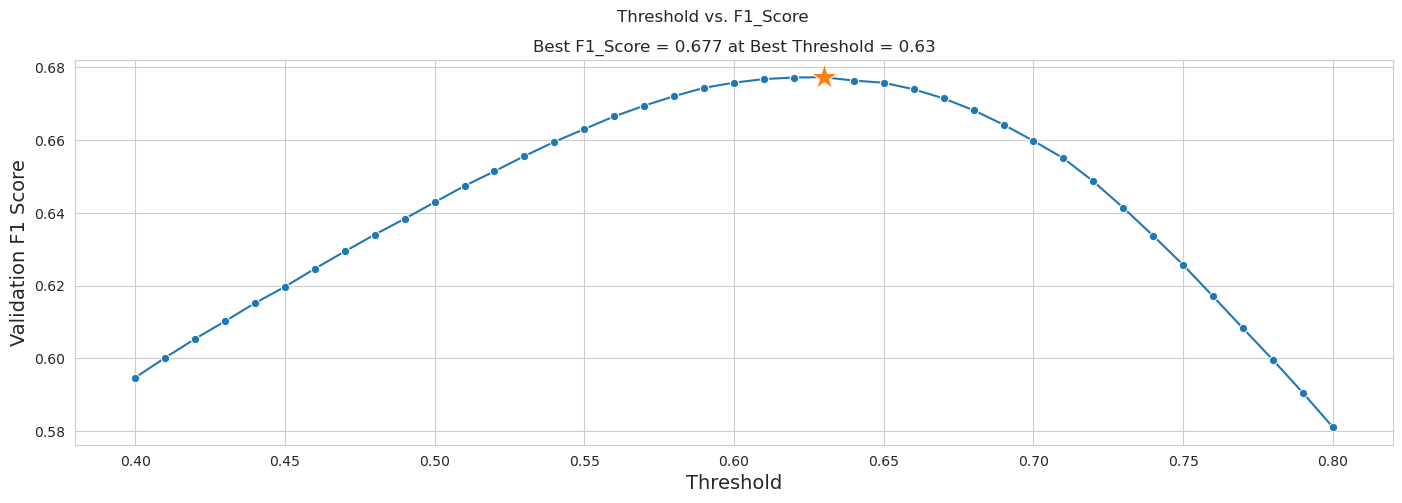

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(17, 5))

sns.lineplot(x=thresholds,y= scores, marker= 'o')
sns.lineplot(x = [best_threshold], y= [best_score], marker= '*', markersize =20)

plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.suptitle('Threshold vs. F1_Score')
plt.title(f'Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}')
plt.show()

In [16]:
f1_dict = {}
for k in range(18):
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    f1_dict[k+1] = m
    
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
f1_df = pd.DataFrame(f1_dict.items(), columns =['Question', 'F1-Score'])

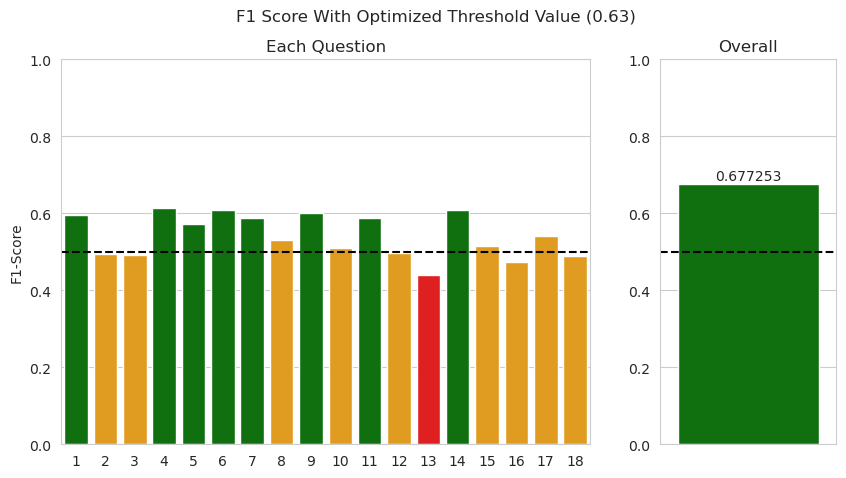

In [17]:
f, axes = plt.subplots(1, 2,figsize=(10, 5),gridspec_kw = {'width_ratios':[3,1]})
color_assignment = ['red' if x < .45 else  'orange' if x < .55 else 'green' for x in f1_df['F1-Score']]

ax1 =sns.barplot(x ='Question', y = 'F1-Score', data =  f1_df, palette = color_assignment,ax=axes[0])
ax1.axhline(.5, ls='--', color= 'black')
ax1.set_ylim(0,1)
ax1.set_title('Each Question')
ax1.set_xlabel('')


ax2 = sns.barplot(x=[1] ,y = [m], palette = ['green'],ax=axes[1])
ax2.axhline(.5, ls='--', color= 'black')
ax2.set_ylim(0,1)
ax2.set_xticks([])
ax2.set_title('Overall')
ax2.bar_label(ax2.containers[0])

f.suptitle(f'F1 Score With Optimized Threshold Value ({best_threshold:.3})')
plt.show()

In [18]:
# IMPORT KAGGLE API
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

# CLEAR MEMORY
import gc
del df_labels, df, oof, true,f1_dict,f1_df
_ = gc.collect()

In [19]:
test ='/kaggle/input/predict-student-performance-from-game-play/test.csv'
sample_submission = '/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv'


In [20]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (test, sample_submission) in iter_test:
    # FEATURE ENGINEER TEST DATA
    test = create_dummies(test,'event_name')
    mem_reduce_test = reduce_mem_usage(test)
    df = feature_engineer_aggregation(mem_reduce_test,'session_id',group_by_columns, column_features)
   # INFER TEST DATA
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[features].astype('float32'))[0,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int( p > best_threshold )
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [23]:
df = pd.read_csv('submission.csv')
print( df.shape )
df.head()

(54, 2)


,session_id,correct
0,20090109393214576_q1,1
1,20090109393214576_q2,1
2,20090109393214576_q3,1
3,20090109393214576_q4,1
4,20090109393214576_q5,0


In [24]:
print(df.correct.mean())

0.6111111111111112
